In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime

np.set_printoptions(precision=3)
pd.set_option('display.max_rows', None)

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [20, 16]

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio   
import plotly.express as px

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import re
re_num = re.compile(r'([0-9\.]+)(.*)')

#import env
os.getcwd()

'/home/ysg/Projects/ai_data_2022'

# 데이터 읽기 / 전처리

- 실험(장비, 소재, 적층 방향 동일)의 시편 데이터들 취합하여 비교하기
- 2022-07-20 현재 새로운 데이터 구조 
- json 파일 오류 및 관련 문의사항  
    * scan_speed 와 laser_power 값이 바뀐듯 함 
    * lamination_direction 값이 모두 0
    * layers 1995 이런값들이 맞는지 확인 
    * scan_speed 단위는 무슨 뜻인지? 
- 빈 칸 없애기, 단위 처리 등


## Mecanical Property 

In [2]:
# base_dir = os.path.join(f'/home', 'mygenie', 'data',  'AI_DB_CYAUTOTECH', 'new_versions')
base_dir = os.path.join(f'/data',  'AI_DB_CYAUTOTECH', '20220720')
!ls -al "$base_dir"

합계 328
drwxrwsr-x+ 82 kikim dev 4096  7월 27 13:59 .
drwxrwsr-x+  3 kikim dev 4096  7월 26 19:09 ..
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:14 433_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:22 434_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:30 435_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:38 436_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:45 437_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 19:54 438_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:03 439_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:11 440_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:19 441_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:28 442_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:38 443_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:48 444_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 20:56 445_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 26 21:06 446_5_sus_0_1cycle
drwxrwxr-x+  6 kikim dev 4096  7월 

In [3]:
data = dict()
data_list = list()
for i, trial in enumerate(sorted(os.listdir(base_dir))):
    if 'cycle' in trial:
        data_dir = os.path.join(base_dir, trial, 'On_Axis_Images')
        json_dir = os.path.join(base_dir, trial, "Mechanical property")
        meta_info = None
        # open one json file
        json_file = os.path.join(json_dir, 'property.json')
        with open(json_file, encoding='utf-8') as f:
            _info = json.load(f)
            if meta_info is None:
                meta_info = {k:set() for k in _info.keys()}
            for k, v in _info.items():
                if k != 'identifier':
                    meta_info[k].add(v)
        data[int(i)] = meta_info
        
        _data = {k.strip():list(v)[0].strip() for k, v in data[i].items() if len(v) > 0}
        __data = {}
        __data['materials'] = _data['materials.name']
        __data['equitments'] = _data['equipment.name']
        __data['sample_num'] = int(_data['sample_num'])
        __data['layer_num'] = int(_data['layers'])
        __data['laser_power'] = _data['conditions.scan_speed']
        __data['laser_speed'] = _data['conditions.laser_power']
        __data['density'] = _data['density']
        __data['yeild_stress'] = _data['yielding stress']
        __data['tensil_stress'] = _data['tensil stress']
        __data['elongation'] = _data['elongation']
        __data['lamination_direction'] = trial.split('_')[-2] 
        __data['trial_no'] = trial.split('_')[-1].split('cycle')[0]
        ___data = {}
        for k, v in __data.items():
            try: 
                val, unit = re_num.match(v).groups()
                knew = k if len(unit) == 0 else f'{k}({unit})'
                ___data.update({knew : float(val)})
            except: 
                ___data.update({k : v})
                
        data_list.append(___data)
        
df = pd.DataFrame(data_list)
df = df.rename(columns={'laser_power(bits/ms)':'laser_power(w)', 'laser_speed(w)':'laser_speed(bits/ms)'})
df['laser_density'] = np.divide(df['laser_power(w)'], df['laser_speed(bits/ms)']) #df['laser_power'] / df['laser_speed']

display(len(df))
df.iloc[1::16]

80

,materials,equitments,sample_num,layer_num,laser_power(w),laser_speed(bits/ms),density(g/cm^3),yeild_stress(MPa),tensil_stress(MPa),elongation(%),lamination_direction,trial_no,laser_density
1,SUS,Vulcan 500,434,274,264.0,1540.0,7.74,450.59,635.25,28.8,0.0,1.0,0.171429
17,SUS,Vulcan 500,450,274,264.0,1540.0,7.77,456.93,600.54,34.6,0.0,2.0,0.171429
33,SUS,Vulcan 500,466,274,264.0,1540.0,7.82,455.21,634.91,36.5,0.0,3.0,0.171429
49,SUS,Vulcan 500,482,1995,264.0,880.0,7.90,458.31,650.99,44.2,45.0,1.0,0.300000
65,SUS,Vulcan 500,498,1995,264.0,880.0,7.70,479.76,664.54,42.3,45.0,2.0,0.300000


In [4]:
df.columns

Index(['materials', 'equitments', 'sample_num', 'layer_num', 'laser_power(w)',
       'laser_speed(bits/ms)', 'density(g/cm^3)', 'yeild_stress(MPa)',
       'tensil_stress(MPa)', 'elongation(%)', 'lamination_direction',
       'trial_no', 'laser_density'],
      dtype='object')

### On-axis Images

In [5]:
from PIL import Image
import cv2

In [6]:
dir_sus_0 = [d for d in sorted(os.listdir(base_dir)) if 'sus_0' in d]
dir_sus_45 = [d for d in sorted(os.listdir(base_dir)) if 'sus_45' in d]

In [7]:
avg_imgs = []

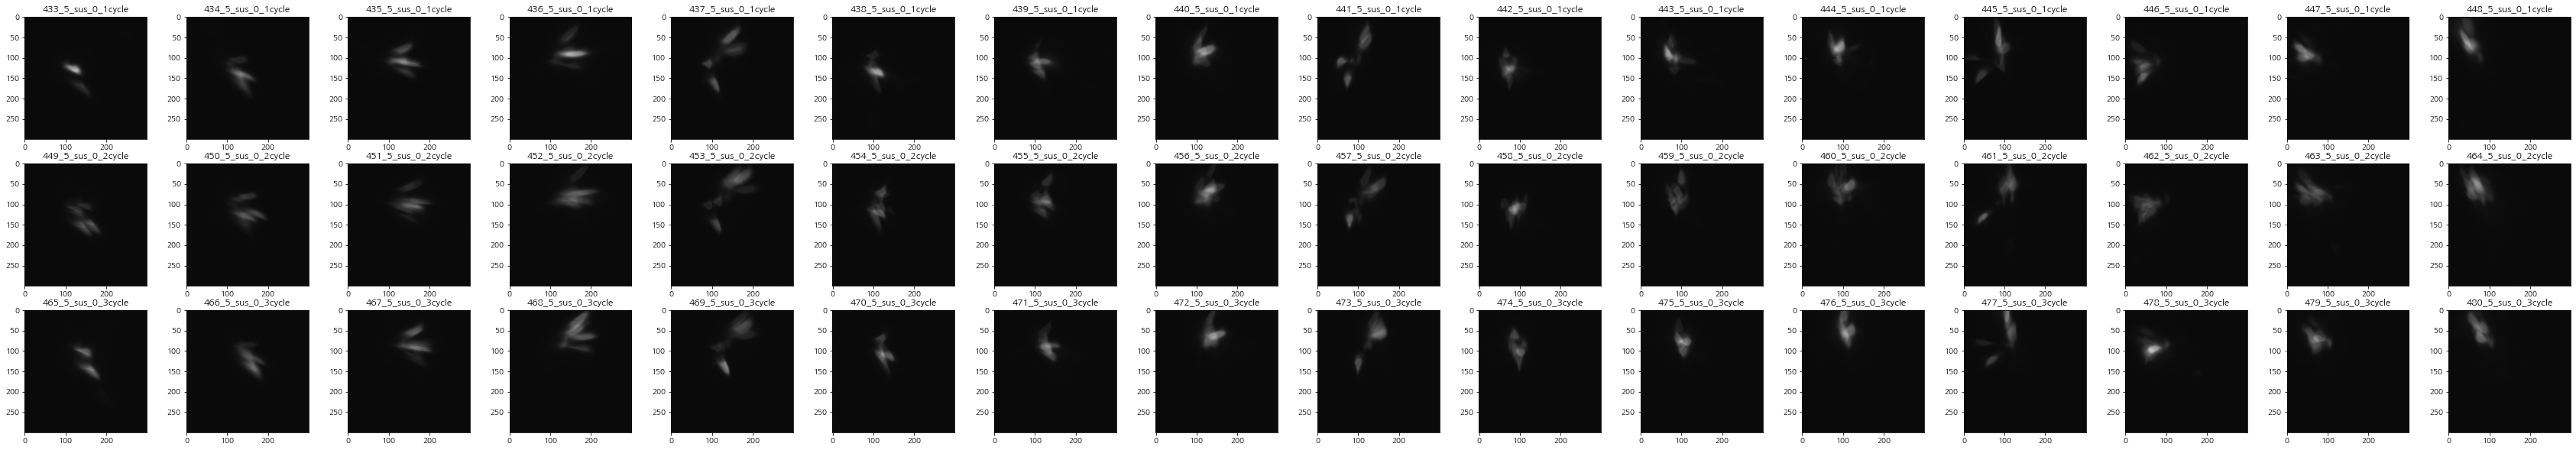

In [8]:
plt.figure(figsize=(60, 10))
for i, d in enumerate(dir_sus_0):
    plt.subplot(3, 16, i + 1)
    
    dir_img = os.path.join(base_dir, d, 'On_Axis_Images')
    img_list = []
    for f in sorted(os.listdir(dir_img))[::1000]:
        #img = plt.imread(os.path.join(dir_img, f))
        #img = Image.open(os.path.join(dir_img, f))
        img = cv2.imread(os.path.join(dir_img, f))
        img_list.append(np.expand_dims(img, axis=3))
    
    avg_img = np.array(np.concatenate(img_list, axis=3).mean(axis=3) / 256, dtype=np.float32)
    avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)
    plt.imshow(avg_img)
    plt.title(d)

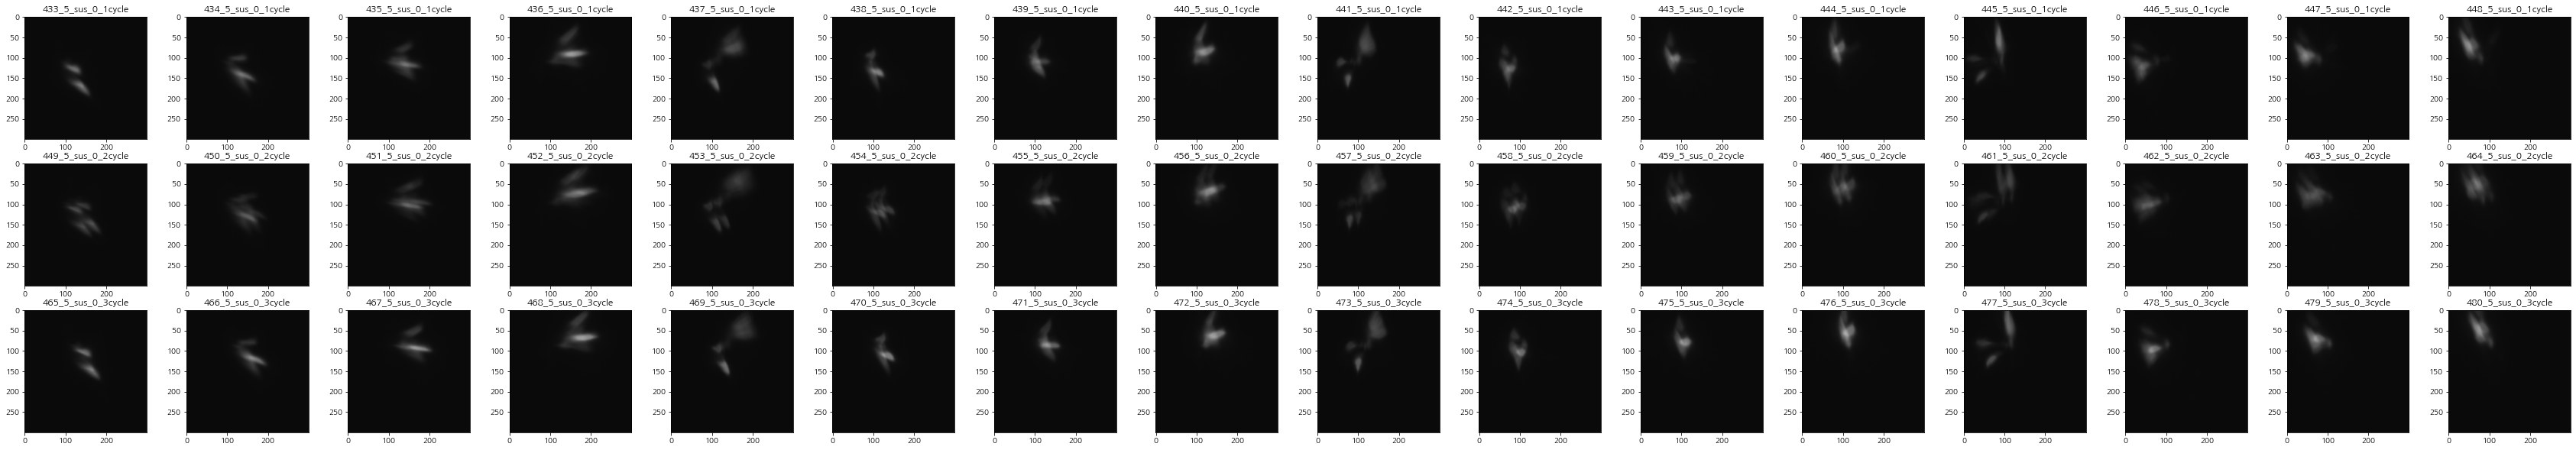

In [9]:
plt.figure(figsize=(60, 10))
for i, d in enumerate(dir_sus_0):
    plt.subplot(3, 16, i + 1)
    
    dir_img = os.path.join(base_dir, d, 'On_Axis_Images')
    img_list = []
    for f in sorted(os.listdir(dir_img))[::100]:
        #img = plt.imread(os.path.join(dir_img, f))
        #img = Image.open(os.path.join(dir_img, f))
        img = cv2.imread(os.path.join(dir_img, f))
        img_list.append(np.expand_dims(img, axis=3))
    
    avg_img = np.array(np.concatenate(img_list, axis=3).mean(axis=3) / 256, dtype=np.float32)
    avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)
    plt.imshow(avg_img)
    plt.title(d)

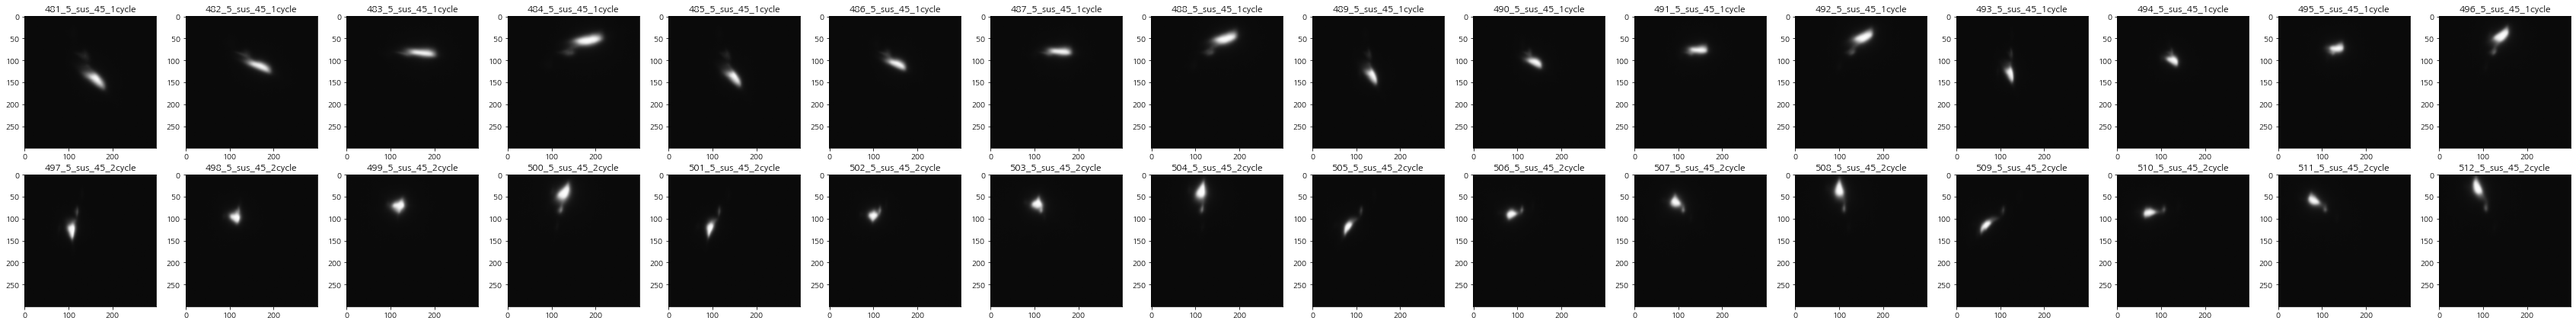

In [10]:
plt.figure(figsize=(60, 7))
for i, d in enumerate(dir_sus_45):
    plt.subplot(2, 16, i + 1)
    
    dir_img = os.path.join(base_dir, d, 'On_Axis_Images')
    img_list = []
    for f in sorted(os.listdir(dir_img))[::100]:
        #img = plt.imread(os.path.join(dir_img, f))
        #img = Image.open(os.path.join(dir_img, f))
        img = cv2.imread(os.path.join(dir_img, f))
        img_list.append(np.expand_dims(img, axis=3))
    
    avg_img = np.array(np.concatenate(img_list, axis=3).mean(axis=3) / 256, dtype=np.float32)
    avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)
    plt.imshow(avg_img)
    plt.title(d)

In [11]:
# _avg_img_arr = np.concatenate([np.expand_dims(img, axis=2) for img in avg_imgs])
# _avg_img_arr.mean(), _avg_img_arr.std()

# Model

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Lambda, Compose

np.random.seed(1)
torch.manual_seed(1)

## data preparation

In [13]:
_df = df.copy()
# _df.set_index('sample_num', inplace=True)

display(len(_df))
_df.head()

80

,materials,equitments,sample_num,layer_num,laser_power(w),laser_speed(bits/ms),density(g/cm^3),yeild_stress(MPa),tensil_stress(MPa),elongation(%),lamination_direction,trial_no,laser_density
0,SUS,Vulcan 500,433,274,240.0,1540.0,7.64,449.14,633.20,25.0,0.0,1.0,0.155844
1,SUS,Vulcan 500,434,274,264.0,1540.0,7.74,450.59,635.25,28.8,0.0,1.0,0.171429
2,SUS,Vulcan 500,435,274,312.0,1540.0,7.72,448.42,632.19,38.5,0.0,1.0,0.202597
3,SUS,Vulcan 500,436,274,360.0,1540.0,7.80,453.55,639.41,38.5,0.0,1.0,0.233766
4,SUS,Vulcan 500,437,274,240.0,1320.0,7.74,473.84,629.69,36.9,0.0,1.0,0.181818


In [14]:
_df.columns

Index(['materials', 'equitments', 'sample_num', 'layer_num', 'laser_power(w)',
       'laser_speed(bits/ms)', 'density(g/cm^3)', 'yeild_stress(MPa)',
       'tensil_stress(MPa)', 'elongation(%)', 'lamination_direction',
       'trial_no', 'laser_density'],
      dtype='object')

In [15]:
prop_cols = ['yeild_stress(MPa)', 'tensil_stress(MPa)', 'elongation(%)', 'density(g/cm^3)', ]
cond_cols = [
#     'materials', 'equitments', 
    'lamination_direction', 'laser_power(w)', 'laser_speed(bits/ms)', 'laser_density'
]

img_sub_dir='On_Axis_Images'
sub_dir_pattern='{sample_num}_5_{materials.lower()}_{int(lamination_direction)}_{trial_no}', 

In [16]:
#is_train = np.random.rand(len(_df)) < 0.81

# df_train = _df.loc[is_train, :]
# df_test = _df.loc[~is_train, :]

is_train = np.array([i for i in range(len(_df))])
np.random.shuffle(is_train)
df_train = _df.iloc[is_train[:64], :]
df_test = _df.iloc[is_train[64:], :]

In [17]:
display(len(df_train))
df_train.head()

64

,materials,equitments,sample_num,layer_num,laser_power(w),laser_speed(bits/ms),density(g/cm^3),yeild_stress(MPa),tensil_stress(MPa),elongation(%),lamination_direction,trial_no,laser_density
63,SUS,Vulcan 500,496,1995,360.0,1540.0,7.76,469.00,645.35,40.4,45.0,1.0,0.233766
27,SUS,Vulcan 500,460,274,360.0,1100.0,7.89,465.02,655.51,36.5,0.0,2.0,0.327273
31,SUS,Vulcan 500,464,274,360.0,880.0,7.71,444.66,659.68,38.5,0.0,2.0,0.409091
69,SUS,Vulcan 500,502,1995,264.0,1100.0,7.75,483.22,658.94,44.2,45.0,2.0,0.240000
46,SUS,Vulcan 500,479,274,312.0,880.0,7.86,485.32,657.96,38.5,0.0,3.0,0.354545


In [18]:
display(len(df_test))
df_test.head()

16

,materials,equitments,sample_num,layer_num,laser_power(w),laser_speed(bits/ms),density(g/cm^3),yeild_stress(MPa),tensil_stress(MPa),elongation(%),lamination_direction,trial_no,laser_density
28,SUS,Vulcan 500,461,274,240.0,880.0,7.85,473.64,647.06,38.5,0.0,2.0,0.272727
11,SUS,Vulcan 500,444,274,360.0,1100.0,7.87,451.94,642.66,38.5,0.0,1.0,0.327273
18,SUS,Vulcan 500,451,274,312.0,1540.0,7.81,468.29,625.68,38.5,0.0,2.0,0.202597
20,SUS,Vulcan 500,453,274,240.0,1320.0,7.88,465.90,630.88,40.4,0.0,2.0,0.181818
50,SUS,Vulcan 500,483,1995,312.0,880.0,7.82,458.76,639.12,44.2,45.0,1.0,0.354545


In [19]:
def sample_to_sub_dir(sample : pd.Series, ):
    sample_num = sample['sample_num']
    material = sample['materials'].lower()
    lam_dir = int(sample['lamination_direction'])
    trial_no = int(sample['trial_no'])
    
    return f'{sample_num}_5_{material}_{lam_dir}_{trial_no}cycle'


def read_avg_image(img_dir, num_img=100):
    img_list = []
    
    img_files = np.random.choice(sorted(os.listdir(img_dir)), num_img)
    
    for f in img_files:
        if os.path.exists(os.path.join(dir_img, f)):
            img = cv2.imread(os.path.join(dir_img, f))
            img_list.append(np.expand_dims(img, axis=3))
    
    avg_img = np.array(np.concatenate(img_list, axis=3).mean(axis=3) /256 , dtype=np.float32)
    avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)
    return avg_img 


In [20]:
avg_img_list = []


In [21]:
# img_list = []

# for i, row in df_train.iterrows():
#     sample = row#.to_frame().transpose()
#     sample_to_sub_dir(sample)
#     sub_dir = sample_to_sub_dir(sample)
#     img_dir = os.path.join(base_dir, sub_dir, img_sub_dir)
#     img = read_avg_image(img_dir, 10)
#     img_list.append(np.expand_dims(img, axis=2))
    
# avg_img_arr = np.concatenate(img_list, axis=2)

# img_mean, img_std = avg_img_arr.mean(), avg_img_arr.std()
# img_mean, img_std

In [22]:
class SpecimenDataset(Dataset):
    
    def __init__(self, df, base_dir, 
                 transform_x=None, 
                 transform_x_img=None,
                 transform_y=None):
        self.df = df
        self.base_dir = base_dir
        self.img_sub_dir = img_sub_dir
        
        self.transform_x = transform_x
        self.transform_x_img = transform_x_img
        self.transform_y = transform_y
        
    def __getitem__(self, idx):
        
        sample = self.df.iloc[idx, :]
        sample_num = sample['sample_num']
        
        x = sample[cond_cols].values
        y = sample[prop_cols].values
        
        sub_dir = sample_to_sub_dir(sample)
        img_dir = os.path.join(self.base_dir, sub_dir, img_sub_dir)
        x_img = read_avg_image(img_dir)
        x_img = x_img.transpose(2,0,1)        
        
        if self.transform_x is not None:
            x = np.array(self.transform_x(x), dtype=np.float32)
            
        if self.transform_x_img is not None:
            x_img = np.array(self.transform_x_img(x_img), dtype=np.float32)
            
        if self.transform_y is not None:
            y = np.array(self.transform_y(y), dtype=np.float32)
    
        return (x, x_img, y, sample_num, idx)
        #return (x.astype(np.float32), x_img.astype(np.float32), y.astype(np.float32), sample_num, idx)
    
    
    def __len__(self):
        return len(self.df)
        
        
class Normalizer:
    """
    최소/최대 [-1, 1] 범위로 정규화
    """ 
    def __init__(self, mins=np.zeros(0), maxs=np.zeros(0), diffs=np.ones(0)):
        self.mins = mins
        self.maxs = maxs
        self.diffs = diffs
        
    def fit(self, array):
        self.mins = array.min(axis=0)
        self.maxs = array.max(axis=0)
        self.diffs = (self.maxs - self.mins) * 0.5
        
        return self
        
    def __call__(self, sample):
        return (sample - self.mins) / self.diffs - 1
    
    def inverse_tranform(self, normalized):
        return (normalized + 1) * self.diffs[None, :] + self.mins[None, :]


class Standardizer:
    """
    정규화
    """ 
    def __init__(self, means=np.zeros(0), stds=np.ones(0)):
        self.means = means
        self.stds = stds
        
    def fit(self, array):
        self.means = array.mean(axis=0)
        self.stds = array.std(axis=0)
        
        self.stds[self.stds == 0] = 1
        
        return self
        
    def __call__(self, sample):
        return (sample - self.means) / self.stds
    
    def inverse_tranform(self, normalized):
        return normalized * self.stds[None, :] + self.means[None, :]


In [23]:
normalizer_x = Standardizer().fit(df_train[cond_cols].values)
normalizer_y = Standardizer().fit(df_train[prop_cols].values)

transform_x = Compose([normalizer_x])
transform_y = Compose([normalizer_y])

In [24]:
## 이미지의 경우 대다수의 픽셀이 0, 불꽃 부위만 256에 가까운 값을 가져서, [-1, 1] 범위로 변환만 함

#transform_x_img = Compose([Lambda(lambda x: x / 256. * 2 - 1)])
transform_x_img = Compose([Lambda(lambda x: x *2 -1 )])

In [25]:
train_dataset = SpecimenDataset(df_train, base_dir, transform_x=transform_x, transform_x_img=transform_x_img, transform_y=transform_y)
test_dataset = SpecimenDataset(df_test, base_dir, transform_x=transform_x, transform_x_img=transform_x_img, transform_y=transform_y)

print(len(train_dataset))
print(len(test_dataset))

64
16


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from resnet import ResNet, BasicBlock
from munch import Munch

#torch.backends.cudnn.enabled=False

class DataModule(pl.LightningDataModule):
    def __init__(self, params, train_dataset, test_dataset, val_dataset=None):
        super().__init__()

        self.train = train_dataset
        self.val = val_dataset
        self.test = test_dataset
        
    def train_dataloader(self, shuffle=True, drop_last=True):
        train_loader = DataLoader(dataset=self.train, 
                                  batch_size=params.batch_size, 
                                  num_workers=params.num_workers,
                                  shuffle=shuffle,
                                  drop_last=drop_last)
        return train_loader
            
    def val_dataloader(self, shuffle=False, drop_last=True):
        if self.val:
            val_loader = DataLoader(dataset=self.val, 
                                    batch_size=params.batch_size, 
                                    num_workers=params.num_workers,
                                    shuffle=shuffle,
                                    drop_last=drop_last)
            return val_loader
        else:
            return None
            
    def test_dataloader(self, shuffle=False, drop_last=True):
        test_loader = DataLoader(dataset=self.test, 
                        batch_size=params.batch_size, #self.test.__len__(), 
                        num_workers=params.num_workers,
                        shuffle=shuffle,
                        drop_last=drop_last)
        return test_loader

def create_model():
    return ResNet(BasicBlock, [1,1,1,1], num_classes=1)
#return _resnet("resnet", BasicBlock, [1,1,1,1], pretrained=False, progress=False, num_classes=1)

class RegressionModule(LightningModule):
    def __init__(self, params):
        super().__init__()
        self.learning_rate = params.learning_rate
        self.weight_decay = params.weight_decay
        self.output_size = params.output_size
        self.input_size = params.input_size
        self.hidden_size = params.hidden_size
        self.num_layers = params.num_layers
        
        #self.img_encoder = create_model()
        self.img_encoder = ResNet(BasicBlock, [1,1,1,1], num_classes=256)
        #self.model = _resnet("resnet", BasicBlock, [1,1,1,1], pretrained=False, progress=False, num_classes=1)
        
        inp_encoder = [
            nn.Linear(self.input_size, 16), nn.ReLU(), nn.Dropout(params.dropout), 
        ]
        self.inp_encoder = nn.Sequential( *inp_encoder )
        layers = [
            nn.Linear(272, 128), nn.ReLU(), nn.Dropout(params.dropout), 
            nn.Linear(128, 32), nn.ReLU(), nn.Dropout(params.dropout), 
            nn.Linear(32, self.output_size),
        ]
        self.layers = nn.Sequential( *layers )
      
    
    def forward(self, x_inp, x_img, ): #[B,L,I]
        
        out_img = self.img_encoder(x_img)
        out_inp = self.inp_encoder(x_inp)
        out = torch.cat((out_img.view(-1, 256), out_inp.view(-1, 16)), dim=-1)
        return self.layers(out)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=self.learning_rate, 
                                     weight_decay=self.weight_decay) 
        return optimizer
    
    def _step(self, batch, mode='train'):
        x_inp, x_img, y, sample_num, idx = batch
        
        if torch.cuda.is_available():
            x_inp, x_img, y = x_inp.cuda(), x_img.cuda(), y.cuda()
        y_pred = self.forward(x_inp, x_img)
        loss = F.mse_loss(y_pred, y)
        self.log('{}_loss'.format(mode), loss)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._step(batch, mode='train')
    
    def validation_step(self, batch, batch_idx):
        return self._step(batch, mode='val')
    
    def test_step(self, batch, batch_idx):
        return self._step(batch, mode='test')

    
def he_init(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

def to_gpu(module):
    device = torch.cuda.current_device()
    module.to(device)

In [27]:
#from sklearn.metrics import mean_absolute_percentage_error 
from scipy import stats
from sklearn.metrics import r2_score 
import seaborn as sns
import warnings 
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "notebook"

warnings.simplefilter(action='ignore', category=FutureWarning)

def evaluation(model, test_loader):
    y_real = list()
    y_pred = list()
    x_real = list()
    with torch.no_grad():
        if params.gpu:
            model = model.cuda()
        for batch in test_loader:
            x_inp, x_img, y, sample_num, idx = batch
            if params.gpu:
                x_inp, x_img, y = x_inp.cuda(), x_img.cuda(), y.cuda()

            y_real.extend(y.data.cpu().numpy())
            x_real.append(x_inp.data.cpu().numpy())
            _y_pred = model.forward(x_inp, x_img)
            y_pred.extend(_y_pred.data.cpu().numpy())

    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(-1)
    y_real = np.array(y_real)
    y_real = y_real.reshape(-1)
    x_real = np.array(x_real)
    x_real = x_real.reshape((-1, x_real.shape[-1]))
    print(x_real.shape, y_pred.shape, y_real.shape)
    
    return y_pred, y_real, x_real


def cal_mape(y_pred, y_real):
    #return mean_absolute_percentage_error(y_real, y_pred) * 100
    #non_zero = np.where(y_real != 0.0)
    non_zero = np.where(np.abs(y_real) > 1e-6)
    out = np.abs(np.divide((y_pred[non_zero] - y_real[non_zero]), y_real[non_zero]))
    return np.nansum(out) / (y_real.shape[0]) * 100

def cal_rmse(y_pred, y_real):
    non_zero = np.where(np.abs(y_real) > 1e-6)
    out = np.sqrt( np.sum(np.square((y_pred[non_zero] - y_real[non_zero])))/ (y_real.shape[0]))
    return out

def cal_r2(y_pred, y_real):
    return r2_score(y_real, y_pred)
#     ss_res = np.sum( np.square(y_real - y_pred) ) 
#     ss_tot = np.sum( np.square(y_real - np.mean(y_real)))
#     return 1 - ss_res / ss_tot

def cal_spearmanr(y_pred, y_real):
    return stats.spearmanr(y_pred, y_real, nan_policy='omit') 

def plotly_compact(data, title=None, static=True, xdata=None):
    fig = make_subplots()
    for key, val in data.items():
        if xdata is None:
            fig.add_trace(go.Scatter(y=val, name=key))
        else:
            fig.add_trace(go.Scatter(x=xdata, y=val, name=key))
            
    _layout_dict = dict()
    if title:
        _layout_dict['title'] = title
    #_layout_dict['yaxis'] = dict(range=[750, 1050 ],)
    #_layout_dict['xaxis'] = dict(range=[17350, 17850],)

    if static:
        _layout_dict['width'] = 1600
        fig.update_layout(_layout_dict)
        fig.show(renderer="png")  
    else:
        fig.update_layout(_layout_dict)
        fig.show()
    

def summarize(model, trainer, params, data_module, dataset=None, static_plot=True): 
    #mse = trainer.test(model)
    dm_loaders = Munch( train = data_module.train_dataloader(shuffle=False), 
                        val = data_module.val_dataloader(shuffle=False), 
                        test = data_module.test_dataloader(shuffle=False))
    if dataset:
        df_set = Munch( train = dataset.train, 
                        val = dataset.val, 
                        test = dataset.test )
    print('experiment {}'.format(params.exp_title))
    print('-'*20)
    exp_results = list()
    #fig = plt.figure(figsize=(6*5, 6*2))
    #axes = fig.subplots(1,1, sharey=True).flatten()
    exp_results = pd.DataFrame([])
    tag_mode = ['train', 'test'] #'val'
    for mode in tag_mode:  
        y_pred, y_real, x_real = evaluation(model, dm_loaders[mode])   
        df_results = Munch(
            #predicted = np.array( [inverse_transform(y, dataset.scaler, idx_y) for y in y_pred[:,i] ]), 
            #real = np.array( [inverse_transform(y, dataset.scaler, idx_y) for y in y_real[:,i] ]), 
            predicted = y_pred ,
            real = y_real
        )
        
        mape = cal_mape(df_results.predicted, df_results.real)
        rmse = cal_rmse(df_results.predicted, df_results.real)
        r2 = cal_r2(df_results.predicted, df_results.real)
        spearmanr = cal_spearmanr(df_results.predicted, df_results.real)
        title = '[{}] {}\n'.format(params.exp_title, mode)
        data = {
            'mode': mode,
            'mape': mape,
            'rmse': rmse,
            'r2': r2, 
            'spearmanr': '{}'.format(spearmanr),    
        }
        print('mape      ({}): {:.6f}'.format(mode, mape))
        print('rmse      ({}): {:.6f}'.format(mode, rmse))
        print('r2        ({}): {:.6f}'.format(mode, r2))
        print('spearmanr ({}): {}'.format(mode, spearmanr))
        if exp_results.shape[0] <= 0:
            exp_results = pd.DataFrame(data, index=[0])
        else:
            exp_results = pd.concat([exp_results, pd.DataFrame(data, index=[0])], ignore_index=True)
        plotly_compact(df_results, title=title, static=True, xdata=None)
        
    #plt.legend()
    #plt.show()
    print('experiment {}'.format(params.exp_title))

    models[params.exp_title] = model
    data_modules[params.exp_title] = data_module
    parameters[params.exp_title] = params
    #metric_mse[params.exp_title] = mse
    metric_mape[params.exp_title] = mape
    metric_r2[params.exp_title] = r2
    y_predictions[params.exp_title] = y_pred
    y_reals[params.exp_title] = y_real
    return exp_results

    
def search_model_ckpt(base_dir, exp_title):
    base_dir = os.path.join(os.getcwd(), base_dir)
    model_dir = os.path.join(base_dir, params.exp_title)
    print(sorted(os.listdir(model_dir)))
    model_dir = os.path.join(model_dir, sorted(os.listdir(model_dir))[-1])
    model_dir = os.path.join(model_dir, 'checkpoints')
    model_dir = os.path.join(model_dir, os.listdir(model_dir)[0])
    print(model_dir)
    return model_dir

In [28]:
parameters = Munch() 
y_predictions = Munch()
y_reals = Munch()
metric_mse = Munch()
metric_mape = Munch()
metric_r2 = Munch()
models = Munch()
data_modules = Munch()

log_base_dir = 'logs_resnet_001/'

In [29]:
prop_cols = ['yeild_stress(MPa)', 'tensil_stress(MPa)', 'elongation(%)', 'density(g/cm^3)', ]
cond_cols = ['lamination_direction', 'laser_power(w)', 'laser_speed(bits/ms)', 'laser_density'] #'materials', 'equitments', 

In [38]:
params = Munch(
    window_size=1, 
    batch_size=8, #8, 
    num_workers=16,
    input_size=len(cond_cols), 
    output_size=len(prop_cols),
    hidden_size=32, 
    num_layers=4,
    learning_rate=2e-5,
    max_epochs=100,
    weight_decay=0.0,
    dropout=0.0,
    gpu=torch.cuda.is_available(),
    exp_title='ver02',
    is_train=True, 
    model_path=None,
    )

In [39]:
params.exp_title='ver02'
params.weight_decay=0.0
params.dropout=0.0

# params.is_train=False
# params.model_path=os.path.join(log_base_dir, params.exp_title),
data_module = DataModule(params, train_dataset, test_dataset)

In [40]:
def _build_model(params):
    model = RegressionModule(params)
    return model

def _init_model(params, model):
    if params.is_train:
        model.apply(he_init)       
        if params.gpu:
            model.apply(to_gpu)

    else:
        model_dir = search_mdel_ckpt(params.model_path)
        model_dir = os.path.join(os.path.join(log_base_dir, params.exp_title),'epoch={}.ckpt'.format(params.max_epochs))
        model_ckpt = torch.load(model_dir)
        model.load_state_dict(model_ckpt['state_dict'])
        if params.gpu:
            model.apply(to_gpu)

In [41]:
model = _build_model(params)

if params.is_train:
    _init_model(params, model)
    trainer = pl.Trainer(
        gpus=1, auto_select_gpus=True, 
        max_epochs=params.max_epochs, 
        default_root_dir=os.path.join(log_base_dir, params.exp_title),
        logger=pl.loggers.TensorBoardLogger(log_base_dir, name=params.exp_title))
    trainer.fit(model, data_module)
    trainer.save_checkpoint(os.path.join(os.path.join(log_base_dir, params.exp_title),'epoch={}.ckpt'.format(params.max_epochs)))
else:
    _init_model(params, model)
    trainer = pl.Trainer(gpus=1, auto_select_gpus=True)

Auto select gpus: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs_resnet_001/ver02
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type       | Params
-------------------------------------------
0 | img_encoder | ResNet     | 5.0 M 
1 | inp_encoder | Sequential | 80    
2 | layers      | Sequential | 39.2 K
-------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.306    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ysg/anaconda3/envs/aidb/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:378: UserWarning:

One of given dataloaders is None and it will be skipped.

/home/ysg/anaconda3/envs/aidb/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning:

The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

experiment ver01
--------------------
(64, 4) (256,) (256,)
mape      (train): 192.221236
rmse      (train): 0.818356
r2        (train): 0.330293
spearmanr (train): SpearmanrResult(correlation=0.4455891692625871, pvalue=6.853136776675561e-14)


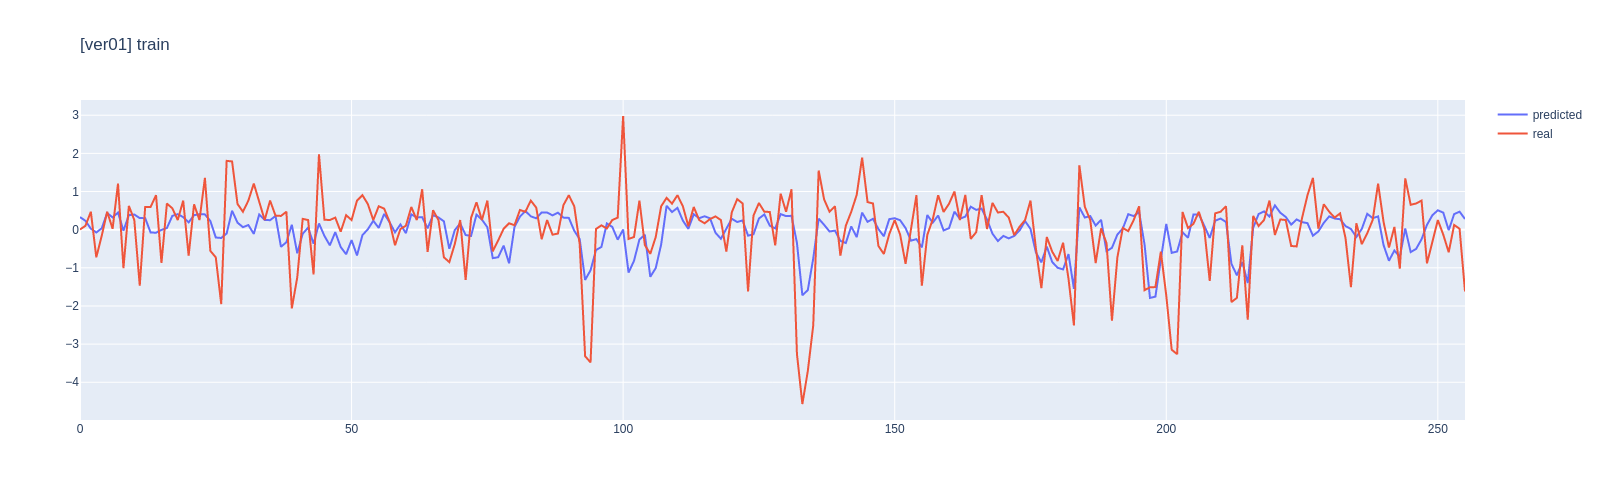

(16, 4) (64,) (64,)
mape      (test): 416.046047
rmse      (test): 0.902983
r2        (test): 0.075103
spearmanr (test): SpearmanrResult(correlation=0.2250759544846589, pvalue=0.07375344285978425)


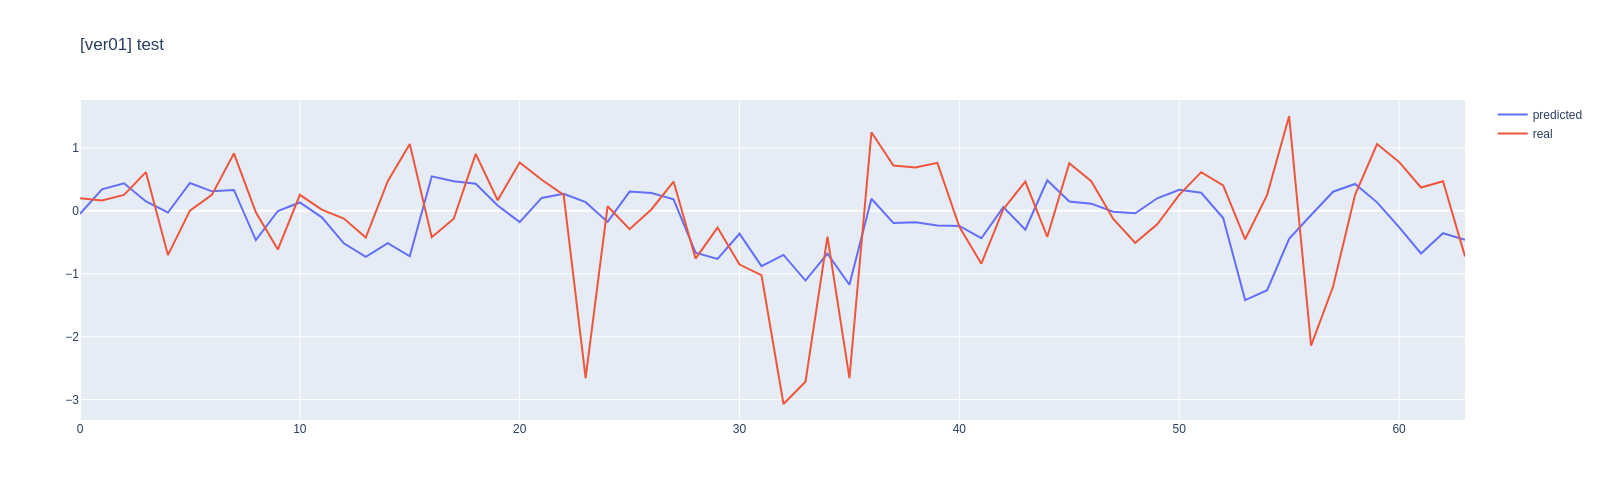

experiment ver01


,mode,mape,rmse,r2,spearmanr
0,train,192.221236,0.818356,0.330293,"SpearmanrResult(correlation=0.4455891692625871, pvalue=6.853136776675561e-14)"
1,test,416.046047,0.902983,0.075103,"SpearmanrResult(correlation=0.2250759544846589, pvalue=0.07375344285978425)"


In [35]:
exp_results = summarize(model, trainer, params, data_module, static_plot=False)
exp_results

In [42]:
%reload_ext tensorboard
%tensorboard --logdir logs_resnet_001 --bind_all

Reusing TensorBoard on port 6006 (pid 157514), started 0:22:08 ago. (Use '!kill 157514' to kill it.)